## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [1]:
!pip install -qq catboost

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as scs
from scipy.signal import find_peaks

import random
random_state=42
random.seed(random_state)
np.random.seed(random_state)

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def adfuller_stats(values):
   dftest = sm.tsa.stattools.adfuller(values)
   dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
   for key,value in dftest[4].items():
     dfoutput['Critical Value (%s)'%key] = value
   return dfoutput

def rolling_means_plt(timeseries, window):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

def tsplot_plt(y, lags=30, figsize=(12, 7), style='bmh'):
    """
    plot: Auto-Correlation graph, Partial AutoCorrelation graph 
    with 
    Time Series Analysis
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


def rmse_error(y_true, y_pred):
  return mean_squared_error(y_true, y_pred, squared=False)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    if plot_intervals:
        tscv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    mape = mean_absolute_percentage_error(prediction, y_test)
    rmse = rmse_error(prediction, y_test)
    plt.title(f"MAPE {mape:.2f}%, RMSE {rmse:.2f}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    
def plotCoefficients(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

# 1. Preparation

In [4]:
pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv").head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
df = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", index_col=['datetime'], parse_dates=['datetime'])

In [6]:
df = df.resample('1h').sum().sort_index()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
target = "num_orders"

# 2. Analysis

In [10]:
def prepare_data(df, target="num_orders", window_size=6, n_lag=25):
  data = df[:]
  data['rolling_mean'] = data[target].shift().rolling(window_size).mean()
  for lag in range(1, n_lag + 1):
    data["lag_{}".format(lag)] = data[target].shift(lag)#, fill_value=0)
  data['dayofweek'] = data.index.dayofweek
  data['month'] = data.index.month
  data['week'] = data.index.week
  data['dayofmonth'] = data.index.day
  data['hour'] = data.index.hour
  data['is_weekend'] = data.dayofweek.isin([5,6])*1
  data = data.dropna()
  return data

In [11]:
data = prepare_data(df)

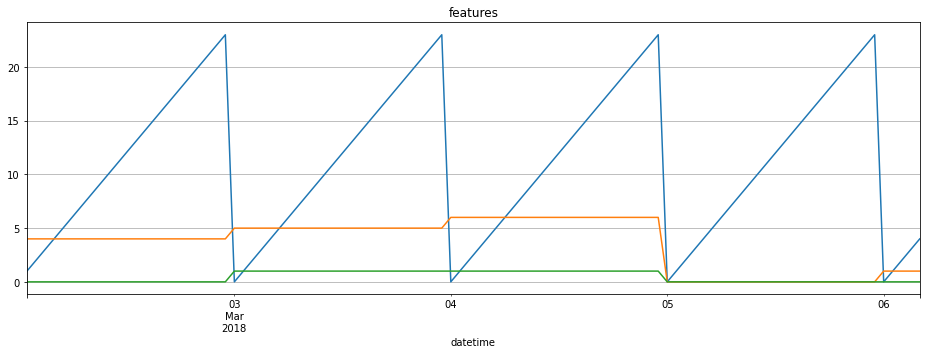

In [38]:
plt.figure(figsize=(16, 5))
plt.title("features")
data[:100].hour.plot()
data[:100].dayofweek.plot()
data[:100].is_weekend.plot()
plt.grid(True);

 Augmented Dickey-Fuller test determine if the series is stationary, let's test it and check p-value

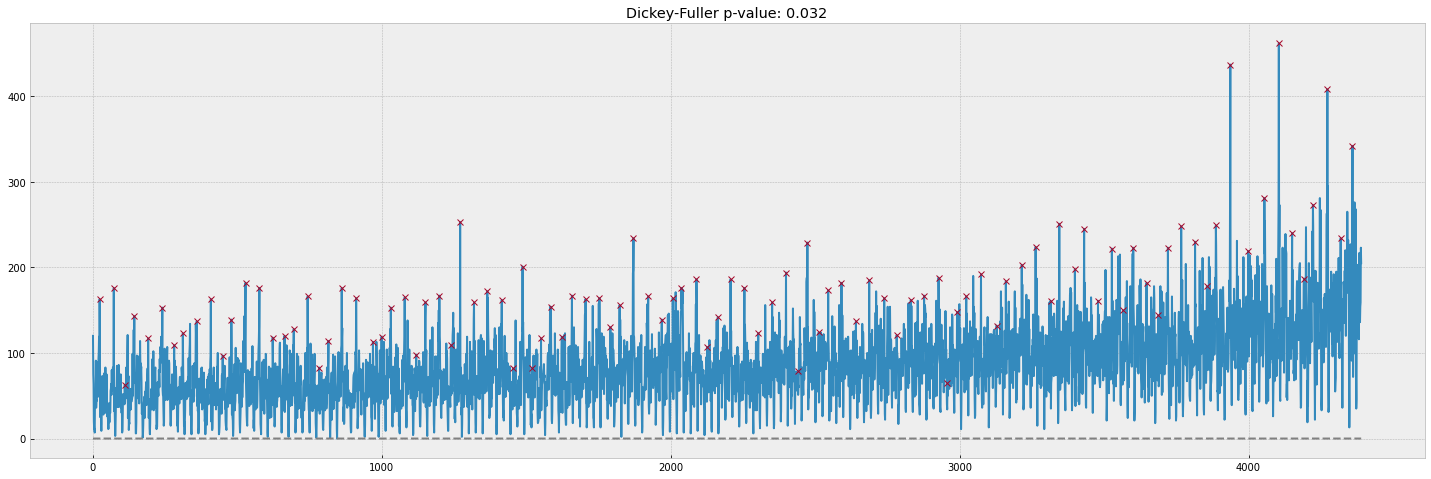

In [12]:
with plt.style.context('bmh'):  
    x = data["num_orders"].values
    peaks, _ = find_peaks(x, distance=30)
    plt.figure(figsize=(25, 8))
    plt.plot(x, label='hour')
    plt.plot(peaks, x[peaks], "x")
    plt.plot(np.zeros_like(x), "--", color="gray")
    plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(data["num_orders"].values)[1], 3)))  
    plt.grid(True)

In [13]:
adfuller_stats(data["num_orders"].values)

Test Statistic                   -3.028709
p-value                           0.032299
#Lags Used                       30.000000
Number of Observations Used    4360.000000
Critical Value (1%)              -3.431851
Critical Value (5%)              -2.862203
Critical Value (10%)             -2.567123
dtype: float64

let's assuming significance α=0.01, therefore we could not reject the null hypothesis, and classify this as stationary


let's plot rolling average (and std)

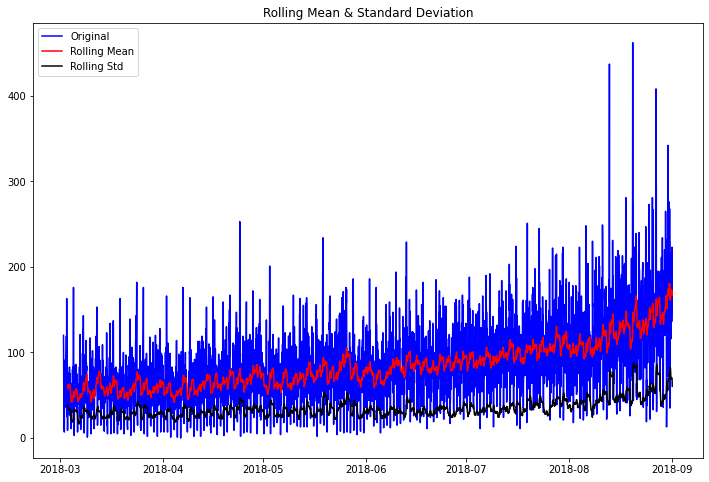

In [14]:
rolling_means_plt(data["num_orders"], window=30)

let's try do stationary model

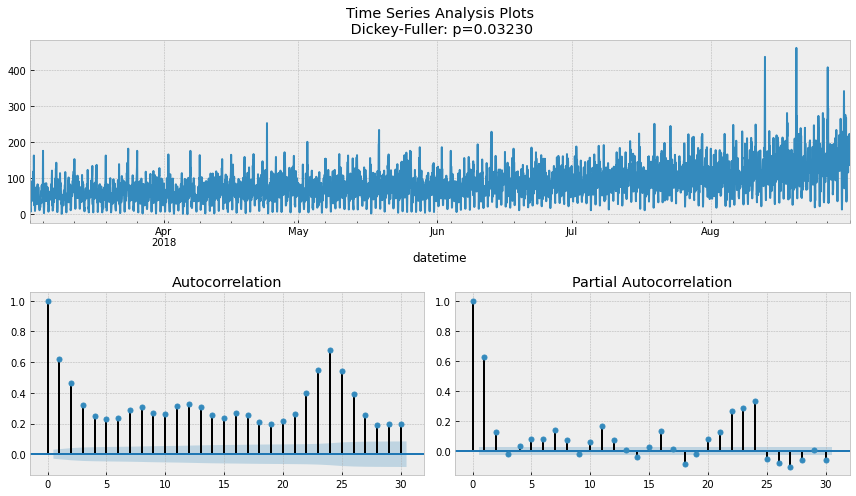

In [15]:
tsplot_plt(data["num_orders"]) 

let's plot autocorellation graphs

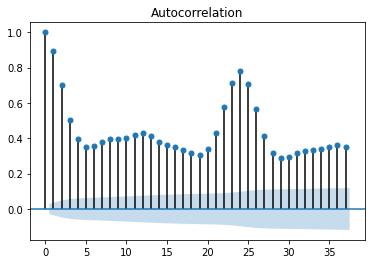

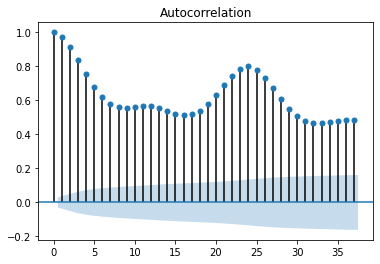

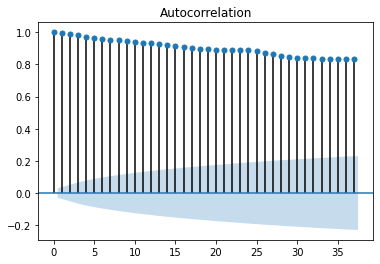

In [16]:
plot_acf(data["num_orders"].rolling(window=3).mean().dropna())
plot_acf(data["num_orders"].rolling(window=7).mean().dropna())
plot_acf(data["num_orders"].rolling(window=30).mean().dropna())
plt.show()

as we could see , we have seasonality, which we have to deal with prior to modeling. let's take the a simple subtraction of the series from itself with a lag that equals the seasonal period

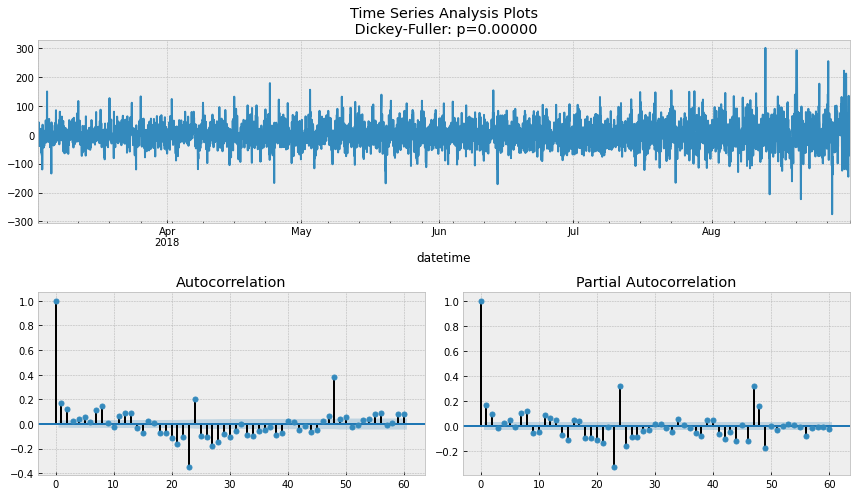

In [17]:
ads_diff = data["num_orders"] - data["num_orders"].shift(23)
tsplot_plt(ads_diff[23:], lags=60)

oscillating around zero, The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. we can 
start modeling

let's see seasonality

for a week

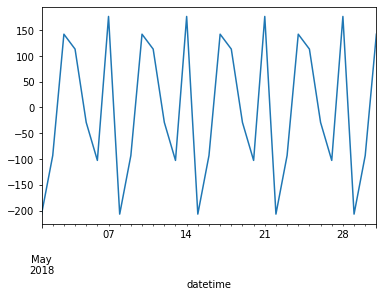

In [18]:
seasonal_decompose(data['2018-05-01':'2018-05-31'].resample('1D').sum().loc[:, target]).seasonal.plot()

for a day

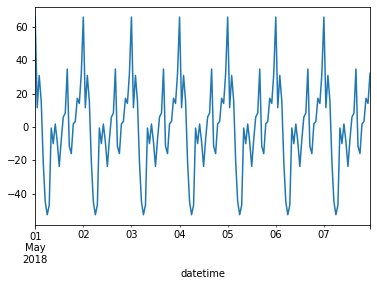

In [19]:
seasonal_decompose(data['2018-05-01':'2018-05-07'].loc[:, 'num_orders']).seasonal.plot(ax=plt.gca())

# 3. Training

# 4. Testing

In [20]:
target = "num_orders"
features = set(data.columns)-set([target])

In [21]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    return X_train, X_test, y_train, y_test

In [22]:
X, y = data[features], data[target]

In [23]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, 0.1)#train_test_split(data[features].values, data[target].values, shuffle=False, test_size=0.1)

In [24]:
print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())

2018-03-02 01:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


### LinearRegression

In [25]:
rows = []
for i in range(1,X_train.shape[1]):
    lr = LinearRegression()
    lr.fit(X_train.iloc[:, :i], y_train)
    y_pred = lr.predict(X_test.iloc[:, :i])
    rows.append(dict(shifted=i, score=1-lr.score(X_test.iloc[:, :i], y_test), MSE=mean_squared_error(y_test, y_pred), RMSE=rmse_error(y_test, y_pred)))
stats_df = pd.DataFrame(rows)
stats_df

,shifted,score,MSE,RMSE
0,1,1.935661,6653.986558,81.571972
1,2,1.729457,5945.142495,77.104750
2,3,1.637772,5629.967701,75.033111
3,4,1.492009,5128.896283,71.616313
4,5,1.250601,4299.038108,65.567050
5,6,1.231512,4233.417025,65.064714
6,7,1.204736,4141.375026,64.353516
7,8,1.207169,4149.739218,64.418470
8,9,1.224976,4210.950428,64.891836
9,10,1.253773,4309.942655,65.650154


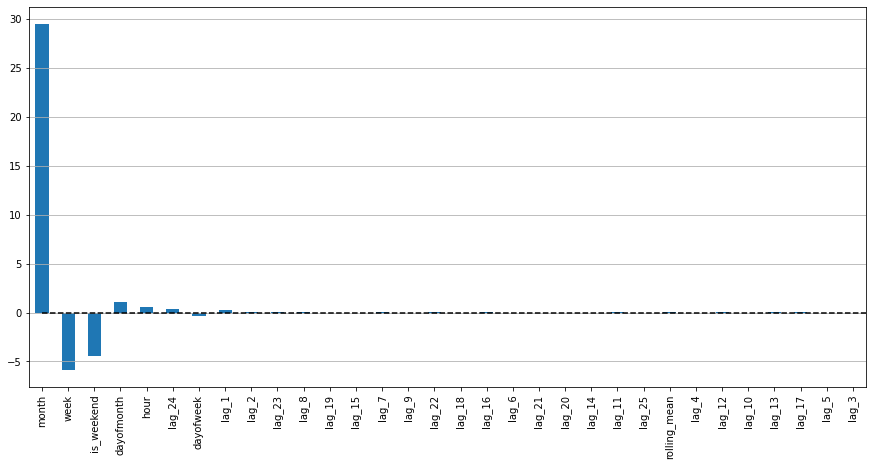

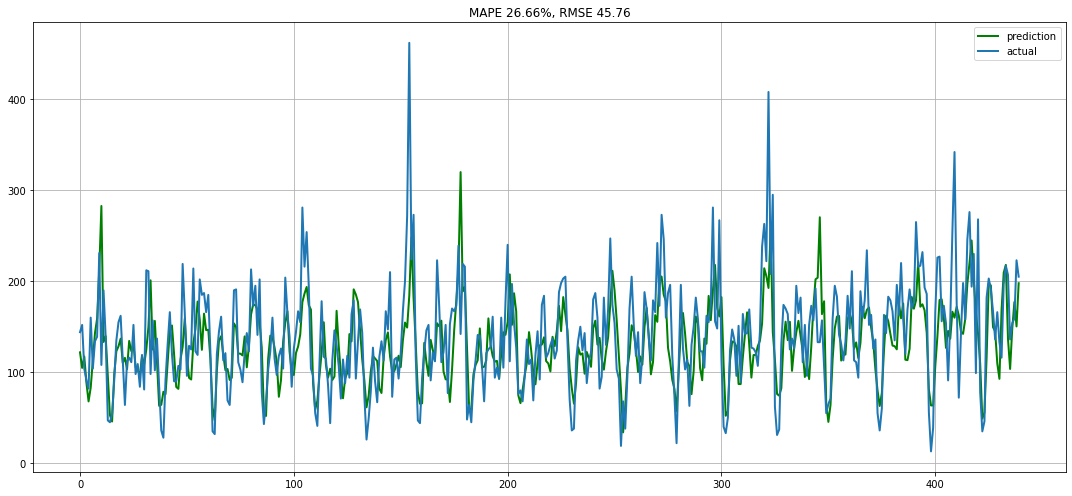

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)
plotCoefficients(lr)
plotModelResults(lr, X_train, X_test, y_train, y_test)

In [27]:
stats_df.iloc[stats_df["RMSE"].argmin()]

shifted      30.000000
score         0.610649
MSE        2099.154475
RMSE         45.816531
Name: 29, dtype: float64

In [28]:
best_shifted = int(stats_df.iloc[stats_df["RMSE"].argmin()]["shifted"])
best_shifted

30

### RandomForestRegressor

In [29]:
model = RandomForestRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)

print(rmse_error(y_pred, y_test))

42.19849990871067


In [30]:
param_grid ={'n_estimators': range(50, 60, 5),
            'max_depth': range(8,16,4),
            'min_samples_split': range(10,40,10),
            'max_features':range(3,10,2)}

lets use mae insted of rmse for avoiding negative results as score

In [31]:
rmse_scorer = make_scorer(rmse_error, greater_is_better=False)

In [32]:
model = RandomForestRegressor(n_estimators=100)
clf = GridSearchCV(model, scoring=rmse_scorer, param_grid=param_grid, n_jobs=4, cv=5).fit(X_train, y_train)
best_params = clf.best_params_

In [33]:
model = RandomForestRegressor(**best_params).fit(X_train, y_train)
y_pred = model.predict(X_test)

print(rmse_error(y_pred, y_test))

40.3841167149077


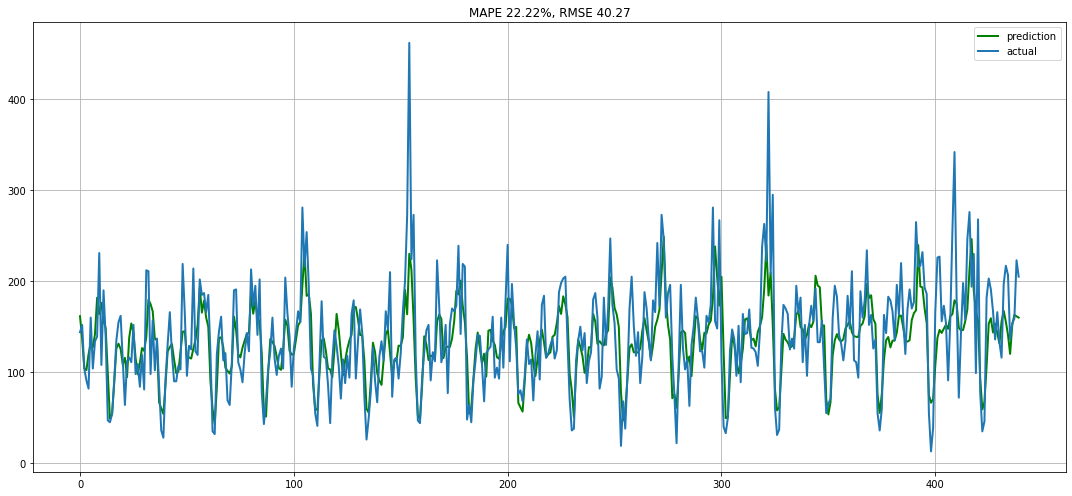

In [34]:
model = RandomForestRegressor(**best_params).fit(X_train, y_train)
plotModelResults(model, X_train, X_test, y_train, y_test)

In [35]:
best_params

{'max_depth': 12,
 'max_features': 9,
 'min_samples_split': 10,
 'n_estimators': 55}

# Summary

we found that our model is non stationary, we built linear model and tree based model and found best result for tree based model and with rmse less than 41 which is enough. also we checked daily changes, week changes and found drift around 22-23 days

# References:

ODS ML time series topic 9:
* [part 1](https://mlcourse.ai/articles/topic9-part1-time-series/)
* [part 2](https://mlcourse.ai/articles/topic9-part2-prophet/)



# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48